In [3]:
!pip install simplejson
!pip install stop_words
!pip install twitter
!pip install credentials

     |████████████████████████████████| 130 kB 5.0 MB/s 
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32912 sha256=850ef2d139f5fca45e7295f2bc72ca3d47c11d50618ea3bdca21c4cb7ce7b6af
  Stored in directory: /root/.cache/pip/wheels/fb/86/b2/277b10b1ce9f73ce15059bf6975d4547cc4ec3feeb651978e9
Successfully built stop-words
     |████████████████████████████████| 50 kB 2.5 MB/s 


In [4]:
import tweepy          
import pandas as pd    
import numpy as np      
import twitter
from credentials import *   
from textblob import TextBlob
from PIL import Image
import re
from stop_words import get_stop_words
from collections import Counter
import simplejson as json

In [ ]:
#API Call for fetching Twitter Data
def userAuthentication():
    auth = tweepy.OAuthHandler('gODObwX686vkj4Wv4AgH0N2Qm', 'oyYRjPcnZOcZJdW3y1r407mj2HTymqtocxIDihnZ4xi0qGoUvT')
    auth.set_access_token('154894359-hPYK2KOyv0sfmW7RjSOUadHWLkFf5a5JcJDa8zzS', 'Uc0s8OOAAES66gBi9SLHk2sJ99rWKehVjgg7bQrT1wuMn')
    twitter_api = tweepy.API(auth)
    return twitter_api
twitter_api = userAuthentication()

#Custom query which takes in any value including hastags, handle ids etc.
query = "@claireperrymp"
msgs=[]
tQryData =  tweepy.Cursor(twitter_api.search, q=query).items(int(500))
for tweet in tQryData:
    msg = [tweet.text,len(tweet.text),tweet.id,tweet.favorite_count,tweet.retweet_count,tweet.source, tweet.source_url,tweet.created_at,tweet.user.profile_image_url,tweet.user.name,tweet.user.screen_name,tweet.geo,tweet.user.location,tweet.entities.get('hashtags')]
    msg = tuple(msg)
    msgs.append(msg)

df = pd.DataFrame(msgs)
df.columns = ['tweets','text_length','id','likes','retweets', 'source', 'url','created_at','image_url','author_name','author_screen_name','geo','location','hashtags']

In [70]:
df1

,Unnamed: 0,Tweets,Useful Complains/Not Useful Complains,Useful/Useless,text_length,id,likes,retweets,source,url,created_at,image_url,author_name,author_screen_name,geo,location,hashtags,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,complaints,useful,Tweets_clean,neg,neu,pos,compound,nb_chars,nb_words,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,doc2vec_vector_3,doc2vec_vector_4,word_ambition,word_arron_banks,word_borisjohnson,...,word_help,word_houseofcommons,word_https,word_important,word_jeremy_hunt,word_know,word_land,word_leave,word_like,word_look,word_make,word_markfielduk,word_michaelgove,word_mp,word_much,word_need,word_network,word_one,word_pay,word_people,word_production,word_right,word_rt,word_say,word_see,word_set,word_start,word_thank,word_theresa_may,word_thing,word_think,word_tmrealityczech,word_tory,word_uk,word_want,word_well,word_work,word_would,word_year,word_yet
0,0,RT @laurafearnfield: @BarristerSecret @clairep...,0.0,0.0,139,1.144550e+18,0.0,2.0,Twitter for iPhone,http://twitter.com/download/iphone,28/06/19 10:07,http://pbs.twimg.com/profile_images/9730909500...,Young Legal Aid Lawyers,YLALawyers,NaN,UK,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rt laurafearnfield barristersecret claireperry...,0.195,0.805,0.000,-0.5574,141,21,-0.049123,0.057244,-0.029596,0.081105,-0.039735,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.85026,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.457472,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
1,1,RT @steviedubyu: Important thread on UK climat...,0.0,1.0,140,1.144550e+18,0.0,5.0,Twitter for iPhone,http://twitter.com/download/iphone,28/06/19 10:06,http://pbs.twimg.com/profile_images/1230141386...,Nick Nuttgens,nicknuttgens,NaN,United Kingdom,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rt steviedubyu important thread uk climate lea...,0.000,0.917,0.083,0.2023,144,23,0.069147,-0.066675,0.087259,0.085786,-0.015253,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.32917,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.171419,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.499869,0.0,0.0,0.0,0.0,0.000000,0.0
2,2,@beisgovuk What about the Â£2bn @UKEF provided...,0.0,1.0,140,1.144540e+18,0.0,0.0,Twitter for iPhone,http://twitter.com/download/iphone,28/06/19 9:28,http://pbs.twimg.com/profile_images/1118396091...,Chris Brennan (â§–),QuietYorkshire,NaN,Yorkshire and The Humber,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,beisgovuk ukef provide uk company fund fossil ...,0.000,1.000,0.000,0.0000,142,20,0.092947,0.072203,0.059827,0.000039,-0.091612,0.0,0.0,0.0,...,0.0,0.0,0.454158,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.464592,0.0,0.0,0.0,0.0,0.601704,0.0
3,3,UK committed nearly Â£2bn to fossil fuel proje...,1.0,1.0,139,1.144520e+18,0.0,0.0,Twitter for iPhone,http://twitter.com/download/iphone,28/06/19 8:05,http://pbs.twimg.com/profile_images/1118396091...,Chris Brennan (â§–),QuietYorkshire,NaN,Yorkshire and The Humber,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,uk commit nearly fossil fuel project abroad la...,0.000,0.877,0.123,0.2732,142,16,-0.074280,0.034679,-0.034553,-0.028004,0.048128,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.594472,0.0,0.0,0.0,0.0,0.769914,0.0
4,4,RT @steviedubyu: Important thread on UK climat...,0.0,1.0,140,1.144510e+18,0.0,5.0,Twitter Web Client,http://twitter.com,28/06/19 7:44,http://pbs.twimg.com/profile_images/8272005387...,Henry Adams,henryadamsUK,NaN,Cumbria UK,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rt steviedubyu important thread uk climate lea...,0.000,0.917,0.083,0.2023,144,23,0.066759,-0.067134,0.086811,0.084450,-0.016652,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.32917,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.171419,0.0,0.0,0.0,0.0,0

In [5]:
import nltk

In [6]:
from nltk.corpus import stopwords 

In [7]:
from nltk.stem.porter import PorterStemmer

In [8]:
#reading csv file for data fecthed by API Call
df1 = pd.read_csv("Tweets.csv")

In [9]:
df1["Tweets"]=df1["Tweets"].astype(str)

In [10]:
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

In [11]:
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [12]:
#Preprocessing and cleaning the data set 
df1["Tweets_clean"] = df1["Tweets"].apply(lambda x: clean_text(x))

In [13]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#creating an instance for sentiment analyser 
sid = SentimentIntensityAnalyzer()
df1["sentiments"] = df1["Tweets"].apply(lambda x: sid.polarity_scores(x))
df1 = pd.concat([df1.drop(['sentiments'], axis=1),df1['sentiments'].apply(pd.Series)], axis=1)


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [14]:
df1.groupby('Useful  Complains/Not Useful Complains')['neg'].count()

Useful  Complains/Not Useful Complains
0.0    161
1.0     38
Name: neg, dtype: int64

In [15]:
# add number of characters column
df1["nb_chars"] = df1["Tweets"].apply(lambda x: len(x))

# add number of words column
df1["nb_words"] = df1["Tweets"].apply(lambda x: len(x.split(" ")))

In [16]:
pip install gensim

In [17]:
import gensim

In [18]:
# create doc2vec vector columns
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(df1["Tweets_clean"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# transform each document into a vector data
doc2vec_df1 = df1["Tweets_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df1.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df1.columns]
df1 = pd.concat([df1, doc2vec_df1], axis=1)

In [18]:
df1.columns

Index(['Unnamed: 0', 'Tweets', 'Useful  Complains/Not Useful Complains',
       'Useful/Useless', 'text_length', 'id', 'likes', 'retweets', 'source',
       'url', 'created_at', 'image_url', 'author_name', 'author_screen_name',
       'geo', 'location', 'hashtags', 'Unnamed: 17', 'Unnamed: 18',
       'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22',
       'complaints', 'useful', 'Tweets_clean', 'neg', 'neu', 'pos', 'compound',
       'nb_chars', 'nb_words', 'doc2vec_vector_0', 'doc2vec_vector_1',
       'doc2vec_vector_2', 'doc2vec_vector_3', 'doc2vec_vector_4'],
      dtype='object')

In [19]:
df2=df1[df1['Useful  Complains/Not Useful Complains']==1]

In [20]:
df3=df1[df1['Useful  Complains/Not Useful Complains']==0]

In [21]:
#Positive Polarity 
df4=df1[df1['compound']>=0]

In [22]:
df4

,Unnamed: 0,Tweets,Useful Complains/Not Useful Complains,Useful/Useless,text_length,id,likes,retweets,source,url,created_at,image_url,author_name,author_screen_name,geo,location,hashtags,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,complaints,useful,Tweets_clean,neg,neu,pos,compound,nb_chars,nb_words,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,doc2vec_vector_3,doc2vec_vector_4
1,1,RT @steviedubyu: Important thread on UK climat...,0.0,1.0,140,1.144550e+18,0.0,5.0,Twitter for iPhone,http://twitter.com/download/iphone,28/06/19 10:06,http://pbs.twimg.com/profile_images/1230141386...,Nick Nuttgens,nicknuttgens,NaN,United Kingdom,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rt steviedubyu important thread uk climate lea...,0.000,0.917,0.083,0.2023,144,23,0.088260,-0.097423,0.044726,-0.087690,-0.041890
2,2,@beisgovuk What about the Â£2bn @UKEF provided...,0.0,1.0,140,1.144540e+18,0.0,0.0,Twitter for iPhone,http://twitter.com/download/iphone,28/06/19 9:28,http://pbs.twimg.com/profile_images/1118396091...,Chris Brennan (â§–),QuietYorkshire,NaN,Yorkshire and The Humber,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,beisgovuk ukef provide uk company fund fossil ...,0.000,1.000,0.000,0.0000,142,20,-0.048904,0.071121,-0.016000,0.024704,0.029699
3,3,UK committed nearly Â£2bn to fossil fuel proje...,1.0,1.0,139,1.144520e+18,0.0,0.0,Twitter for iPhone,http://twitter.com/download/iphone,28/06/19 8:05,http://pbs.twimg.com/profile_images/1118396091...,Chris Brennan (â§–),QuietYorkshire,NaN,Yorkshire and The Humber,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,uk commit nearly fossil fuel project abroad la...,0.000,0.877,0.123,0.2732,142,16,0.007676,-0.096453,0.030113,-0.012937,-0.018619
4,4,RT @steviedubyu: Important thread on UK climat...,0.0,1.0,140,1.144510e+18,0.0,5.0,Twitter Web Client,http://twitter.com,28/06/19 7:44,http://pbs.twimg.com/profile_images/8272005387...,Henry Adams,henryadamsUK,NaN,Cumbria UK,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rt steviedubyu important thread uk climate lea...,0.000,0.917,0.083,0.2023,144,23,0.088536,-0.097680,0.044147,-0.087944,-0.041161
5,5,"What happens now that our ""friends"" and ""allie...",0.0,1.0,140,1.144510e+18,0.0,5.0,Twitter for iPad,http://twitter.com/#!/download/ipad,28/06/19 7:26,http://pbs.twimg.com/profile_images/7742013907...,bakera,bakerainlondon,NaN,Teddington,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,happens friend ally saudi take despotic state ...,0.080,0.747,0.173,0.5204,165,30,-0.015097,0.033645,-0.078889,-0.070013,-0.075922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,436,@claireperrymp @MarkFieldUK Don't come back an...,NaN,NaN,76,1.142820e+18,0.0,0.0,Twitter for Android,http://twitter.com/download/android,23/06/19 15:35,http://pbs.twimg.com/profile_images/7381057881...,Frack Free EQS,frackfreeeqs,NaN,"Bicknoller, England",[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,claireperrymp markfielduk come back anytime so...,0.000,1.000,0.000,0.0000,76,9,0.033606,-0.006757,-0.097423,0.072856,0.061585
404,437,@edgwarerich @ProfJoan100 @tarzanbhoy1967 @cla...,NaN,NaN,80,1.142810e+18,0.0,0.0,Twitter for Android,http://twitter.com/download/android,23/06/19 15:21,http://pbs.twimg.com/profile_images/9573959647...,Aurora #GTTO #BDS,fellaurora,NaN,Durham,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,edgwarerich claireperrymp https://t.co/nyrusczbrc,0.000,1.000,0.000,0.0000,80,5,0.035059,0.004015,0.088400,-0.095624,0.026857
405,438,@edgwarerich @tarzanbhoy1967 @claireperrymp @M...,NaN,NaN,80,1.142810e+18,0.0,0.0,Twitter for Android,http://twitter.com/download/android,23/06/19 15:20,http://pbs.twimg.com/profile_images/9573959647...,Aurora #GTTO #BDS,fellaurora,NaN,Durham,[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,edgwarerich claireperrymp markfielduk https://...,0.000,1.000,0.000,0.0000,80,5,0.003016,-0.071595,-0.082885,0.028506,0.054472
406,439,@edgwarerich @ARedRaven @claireperrymp @MarkFi...,NaN,NaN,140,1.142810e+18,0.0,0.0,T

In [23]:
#Negative Polarity 
df5=df1[df1['compound']<0]

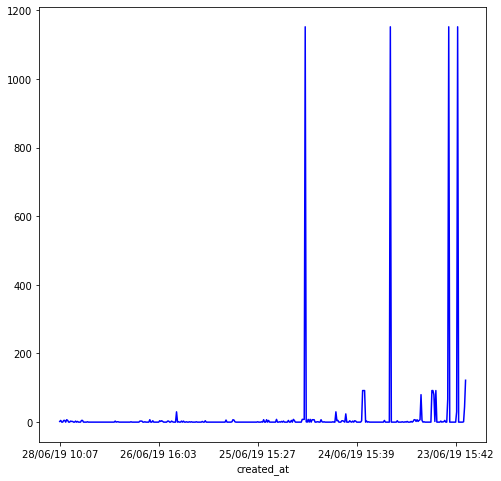

In [33]:
retweets = pd.Series(data=df1['retweets'].values, index=df1['created_at'])
retweets.plot(figsize=(8,8), color='b')

In [25]:
location=df1['location'].value_counts()
location

UK                            26
Windlesham                    21
SWADLINCOTE                   20
London                        14
London, England               13
                              ..
Indeterminate.                 1
Cardiff. Porthcawl. Wales.     1
facebook.com/marfedblog/       1
Middlesbrough                  1
Teddington                     1
Name: location, Length: 110, dtype: int64

Text(0, 0.5, 'Frequency')

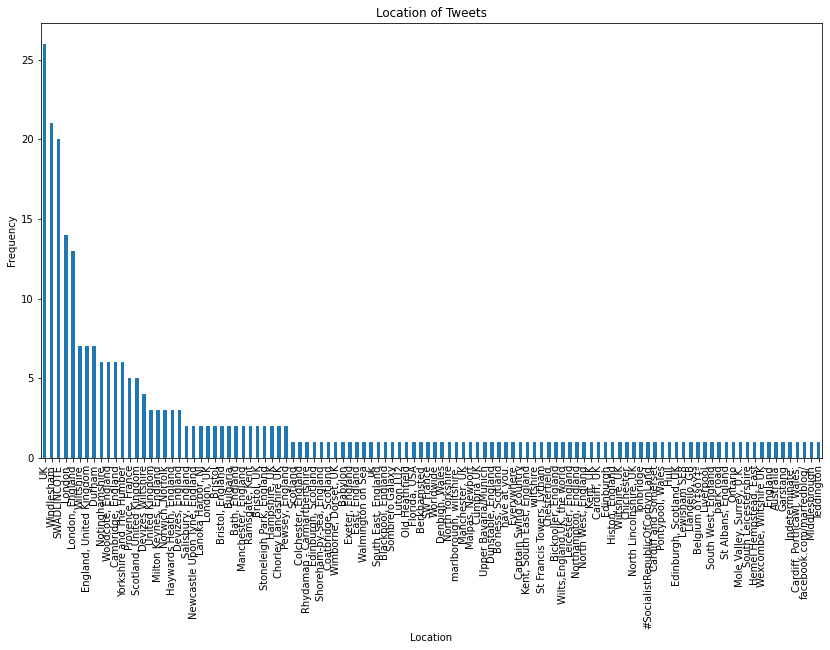

In [26]:
loc = df1['location'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Location of Tweets")
loc.set_xlabel("Location")
loc.set_ylabel("Frequency")

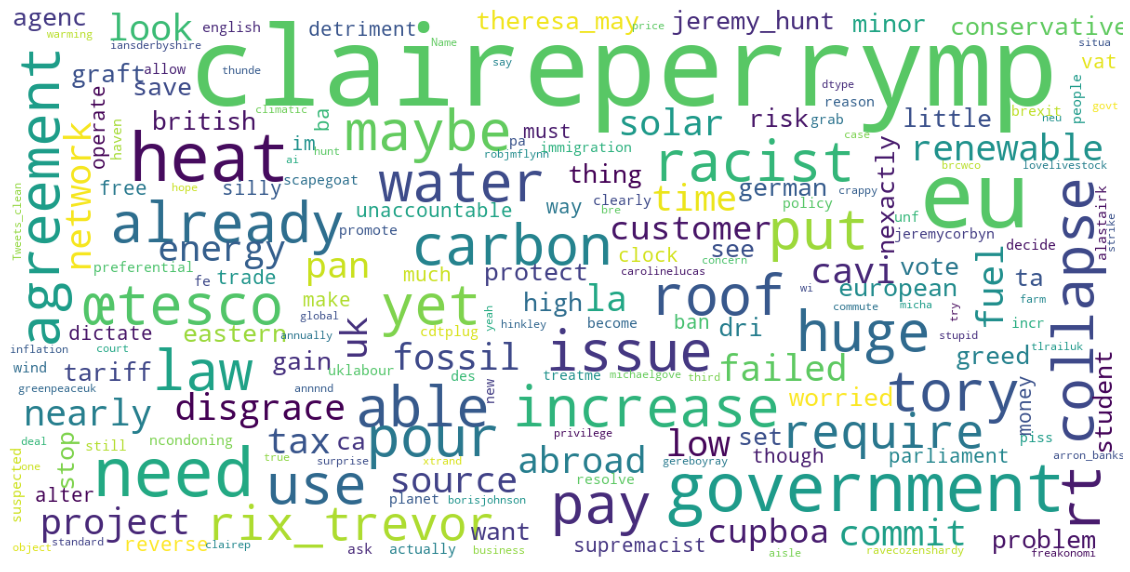

In [27]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(df2["Tweets_clean"])
#view raw

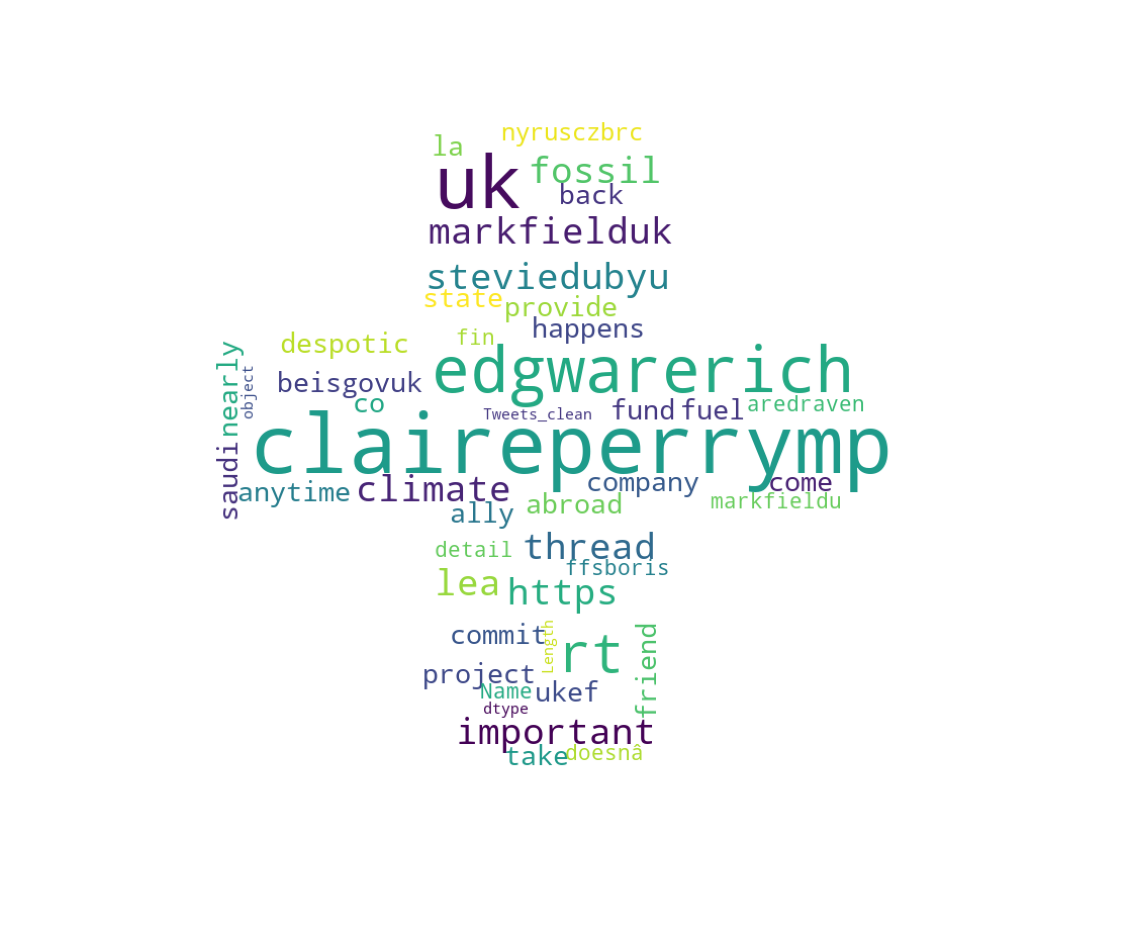

In [28]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    custommask = np.array(Image.open('Plus_Sign.jpeg'))
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        scale = 3,
        mask = custommask,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(df4["Tweets_clean"])
#view raw

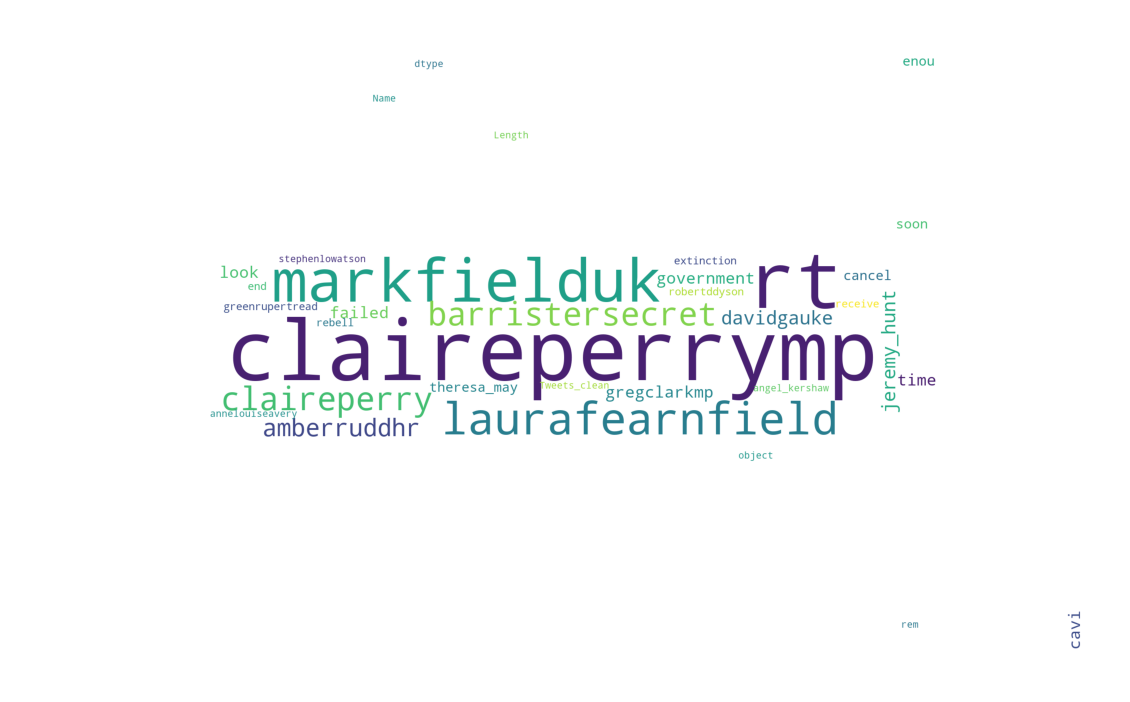

In [29]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    custommask = np.array(Image.open('Minus_Sign.jpeg'))
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200, 
        mask = custommask,
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(df5["Tweets_clean"])
#view raw

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


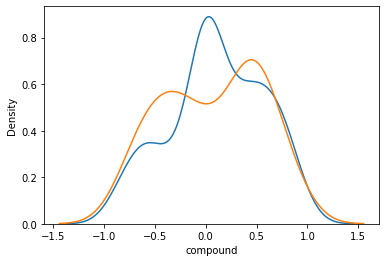

In [30]:
# plot sentiment distribution for positive and negative reviews

import seaborn as sns

for x in [0, 1]:
    subset = df1[df1[ 'Useful  Complains/Not Useful Complains'] == x]
    
    # Draw the density plot
    if x == 0:
        label = "Good reviews"
    else:
        label = "Bad reviews"
    sns.distplot(subset['compound'], hist = False, label = label)

In [34]:
df1.columns

Index(['Unnamed: 0', 'Tweets', 'Useful  Complains/Not Useful Complains',
       'Useful/Useless', 'text_length', 'id', 'likes', 'retweets', 'source',
       'url', 'created_at', 'image_url', 'author_name', 'author_screen_name',
       'geo', 'location', 'hashtags', 'Unnamed: 17', 'Unnamed: 18',
       'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22',
       'complaints', 'useful', 'Tweets_clean', 'neg', 'neu', 'pos', 'compound',
       'nb_chars', 'nb_words', 'doc2vec_vector_0', 'doc2vec_vector_1',
       'doc2vec_vector_2', 'doc2vec_vector_3', 'doc2vec_vector_4'],
      dtype='object')

**REFERENCES**

1. Stojanovski, D., Dimitrovski, I., & Madjarov, G. (2014). Tweetviz: Twitter data
visualization. Proceedings of the data mining and data warehouses, 1(2).
2. Sechelea, A., Do Huu, T., Zimos, E., & Deligiannis, N. (2016, May). Twitter data
clustering and visualization. In 2016 23rd international conference on telecommunications
(ICT) (pp. 1-5). IEEE.
3. Bhulai, S., Kampstra, P., Kooiman, L., Koole, G., Deurloo, M., & Kok, B. (2012). Trend
visualization on Twitter: what’s hot and what’s not?. Data analytics, 43-48.
4. https://analyticsindiamag.com/complete-tutorial-on-text-preprocessing-in-nlp/
5. https://amueller.github.io/word_cloud/auto_examples/masked.html